# **AT&T Spam Detector - Benchmarking**




Contents
--------
1. [Data loading and preprocessing](#loading)
2. [Preliminary data analysis](#eda)
3. [Benchmarking with a logistic regression](#logreg)

In [ ]:
import time
import re
from string import punctuation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (precision_recall_curve,
                             precision_score,
                             recall_score,
                             f1_score)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


SEED = 1234
PROCESSED_FILENAME = './spam_data.npz'

## <a id="loading"></a> Data loading and preprocessing

The dataset consists of 5574 entries, many of which have issues. Here is a non-exhaustive list:
- The file doesn't decode as `UTF-8`. It must be decoded as `latin-1` or `mac-roman`.
- Some rows are ill-formed (eg line 101 of the csv: `ham""",,,`)
- Most rows have trailing commas
- Some messages are anclosed in (possibly many) double quote characters
- Single and double quotes are escaped with backslashes
- Some spurious characters are present (eg `å` characters that systematically prepend pound symbols `£`)

Fortunately, the original version of the dataset can be found [here](https://archive.ics.uci.edu/dataset/228/sms+spam+collection). Its entries are much cleaner than those of our dataset. We can use them as a comparison to setup the cleaning and processing for our dataset:
- Strip the trailing commas
- Completely remove the double quotes `"`
- Convert backslashes + single quote `\'` into single quote `'`
- Convert backslashes `\` into double quotes `"`
- Remove the spurious characters `å`

The implementation of this pipeline is given below.

In [5]:
########## Loading and preprocessing the project dataset ##########
with open('./spam.csv', 'rt', encoding='latin-1') as f:
    f.readline() # remove header
    raw_data = [row.strip().split(',', 1) for row in f.readlines()]

## set target
is_spam = np.array([True if row[0] == 'spam' else False for row in raw_data])

## process and clean messages
messages = [row[1].strip(',') \
                  .replace('"', '') \
                  .replace("\\'", "'") \
                  .replace('\\', '"') \
                  .replace('å', '')
            for row in raw_data]

However, some encoding issues persist with some problematic characters still present in messages. To proceed with the project we will rather use this original dataset as the starting point. The messages still need some processing:
- characters in HTML-escaped form are converted to the corresponding symbol
- The `RIGHT SINGLE QUOTATION MARK` character (`\x92`) is converted into a single quote `'`

In [6]:
########## Loading and preprocessing the original dataset ##########
with open('./SMSSpamCollection', 'rt', encoding='utf-8') as f:
    raw_data = [row.strip().split('\t', 1) for row in f.readlines()]

is_spam = np.array([True if row[0] == 'spam' else False for row in raw_data])
messages = np.array([row[1].replace('&lt;', '<') \
                           .replace('&gt;', '>') \
                           .replace('&amp;', '&') \
                           .replace('\x92', "'")
                     for row in raw_data],
                    dtype=object)

In [7]:
## save to numpy zip
np.savez(PROCESSED_FILENAME, messages=messages, is_spam=is_spam)

In [8]:
df = pd.DataFrame({'message': messages, 'is_spam': is_spam})
df.describe(include='all')

,message,is_spam
count,5574,5574
unique,5160,2
top,"Sorry, I'll call later",False
freq,30,4827


Our dataset contains a total of 5574 messages, with 4827 hams (86.6%) and 747 spams (13.4%). Some messages are duplicates. We choose not to remove them, they certainly represent frequent messages for which making a classification error should be penalized more.

## <a id="eda"></a> Preliminary data analysis

The messages are quite complex, mixing  uppercase, lowercase, puctuation, alphanumeric and other exotic characters. Training a model to the data would certainly require some form of text normalization. However, this might cause a loss of information. In this section we try to somewhat keep this information and aggregate it in the form of a few descriptive to get insight about what makes a message a spam.

An important remark is in order before proceeding with data analysis. Visual inspection of the dataset reveals the presence of some tokens specific to ham messages: `<#>`, `<DECIMAL>`, `<TIME>` and `<URL>` (they appear as `&lt;*&gt;` in the dataset). These were certainly introduced to mask personal information from hams. Although the kind of values that `<DECIMAL>`, `<TIME>` and `<URL>` replace is obvious, this is not the case for `<#>`, which seems to be used in replacement of any kind of value. The character `*` seems to also be used to replace personal information in some ham messages (see for instance message 983). However, this character is also present as such in messages.

In [9]:
tokens_df = pd.DataFrame(
    {'is_spam': df['is_spam'],
     'count_<#>': df['message'].map(lambda x: x.count('<#>')),
     'count_<DECIMAL>': df['message'].map(lambda x: x.count('<DECIMAL>')),
     'count_<TIME>': df['message'].map(lambda x: x.count('<TIME>')),
     'count_<URL>': df['message'].map(lambda x: x.count('<URL>')),
     'count_*': df['message'].map(lambda x: x.count('*'))})

tokens_df.groupby('is_spam').sum()

,count_<#>,count_<DECIMAL>,count_<TIME>,count_<URL>,count_*
is_spam,,,,,
False,276,23,7,3,196
True,0,0,0,0,115


Indeed, these tokens are specific to hams (except the character `*`). There presence, due to human annotations, could introduce important biases to an automated detection system if not handled properly.

With this remark in mind, we can move to the characterization of messages using the following descriptive features:
- `msg_len`, the length of the message;
- `chr_caps`, the number of capitallized characters;
- `chr_digit`, the number of digit characters in the message;
- `chr_punct`, the number of punctuation characters in the message;
- `max_wd_len`, he length of the longest character string (split by whitespaces);
- `lex_money`, the number of some money-related words and characters: `'$'`, `'£'`, `'€'`, `'cash'`, `'free'`, `'price'` and `'prize'`. The presence of these tokens indicates that the message talks about money (after all, spamming is about getting money from people). We could also consider adding words related to the lexical field of sex.
- `caps_first`, the number of consecutive capitallized characters at the beginning of the message.

For the purpose of data visualization, we remove the duplicates in the dataset.

In [10]:
## Define some helper functions
def count_tokens(msgs: pd.DataFrame, tokens: list['str'])-> pd.DataFrame:
    """
    Count the number of tokens in the token list from the casefolded messages.
    """
    regex = '|'.join(tokens)
    return msgs.apply(lambda x: len(re.findall(regex, x.casefold())))
    

def count_first_caps(s: str)-> int:
    """
    Count the number of capitallized letters at the beginning of a string.
    """
    n = 0
    for c in s:
        if not c.isupper():
            return n
        n += 1
    return n


def build_features(msgs: pd.DataFrame)-> pd.DataFrame:
    """
    Extract quantitative features from a series of messages.
    """
    data = {
        'msg_len': msgs.apply(len),
        'chr_caps': msgs.apply(lambda s: sum(c.isupper() for c in s)),
        'chr_digit': msgs.apply(lambda s: sum(c.isdigit() for c in s)),
        'chr_punct': msgs.apply(lambda s: sum(c in punctuation for c in s)),
        'max_wd_len': msgs.apply(lambda s: max(len(x) for x in s.split(' '))),
        'lex_money': count_tokens(msgs, [r'\$', '£', '€', 'free', 'cash', 'price', 'prize']),
        'caps_first': msgs.apply(count_first_caps)
        }
    return pd.DataFrame.from_dict(data)

In [11]:
## Prepare dataset from extracted features
df_ = df.drop_duplicates()
X = build_features(df_['message'])
y = df_['is_spam']

In [12]:
X_spam = X.loc[y]
X_spam.describe().map(lambda x: f"{x:.2f}")

,msg_len,chr_caps,chr_digit,chr_punct,max_wd_len,lex_money,caps_first
count,642.00,642.00,642.00,642.00,642.00,642.00,642.00
mean,137.41,15.15,15.44,5.64,14.23,1.02,1.65
std,29.98,12.57,8.94,3.51,6.85,1.11,1.85
min,13.00,0.00,0.00,0.00,5.00,0.00,0.00
25%,131.00,7.00,9.00,3.00,11.00,0.00,1.00
50%,148.00,13.00,16.00,5.00,12.00,1.00,1.00
75%,157.00,20.00,22.00,8.00,16.00,2.00,1.00
max,223.00,128.00,47.00,26.00,56.00,5.00,11.00


In [13]:
X_ham = X.loc[~y]
X_ham.describe().map(lambda x: f"{x:.2f}")

,msg_len,chr_caps,chr_digit,chr_punct,max_wd_len,lex_money,caps_first
count,4518.00,4518.00,4518.00,4518.00,4518.00,4518.00,4518.00
mean,70.43,3.98,0.30,3.72,8.26,0.02,1.00
std,55.95,10.89,1.02,4.06,2.84,0.17,0.53
min,2.00,0.00,0.00,0.00,2.00,0.00,0.00
25%,33.00,1.00,0.00,1.00,7.00,0.00,1.00
50%,52.00,2.00,0.00,3.00,8.00,0.00,1.00
75%,91.00,3.00,0.00,5.00,9.00,0.00,1.00
max,910.00,129.00,23.00,97.00,49.00,4.00,17.00


Some of our derived features are actually quite discriminating for the spam/ham nature of the messages.
- The number of digits is clearly the most discriminating feature with a mean of 15 for spams vs 0.3 for hams. 75 % of spams have more than 10 digits while less than 25% have a single digit.
- The presence of money-related words 'free', 'cash' and currency characters is also discriminative of spams, although many spams do not have any.
- Spams tend to also have larger message lengths, capitallized characters and punctuation characters. However, there is more overlap between the two categories in this case.

In [14]:
v1, v2 = 'chr_digit', 'max_wd_len'

## number of hams with given values of `v1` and `v2`
count_ham = X_ham.loc[:, [v1, v2]].value_counts()
x_ham, y_ham = count_ham.index.to_frame().to_numpy().T

## number of spams with given values of `v1` and `v2`
count_spam = X_spam.loc[:, [v1, v2]].value_counts()
x_spam, y_spam = count_spam.index.to_frame().to_numpy().T

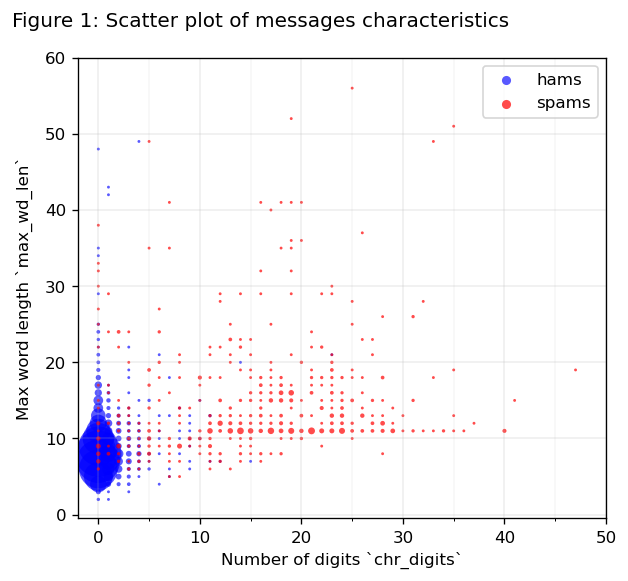

In [22]:
fig1, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(5.5, 4.8), dpi=120,
    gridspec_kw={'left': 0.12, 'right': 0.92, 'top': 0.9, 'bottom': 0.10}
)
fig1.suptitle('Figure 1: Scatter plot of messages characteristics',
              x=0.02, ha='left')

sc_ham = ax1.scatter(x_ham, y_ham, count_ham+2,
                     c='blue', alpha=0.65, marker='o', linewidths=0,
                     label='hams')
sc_spam = ax1.scatter(x_spam, y_spam, count_spam+2,
                      c='red', alpha=0.7, marker='o', linewidths=0,
                      label='spams')

ax1.set_xlim(-2, 50)
ax1.set_xticks(np.arange(5, 50, 5), minor=True)
ax1.set_xlabel('Number of digits `chr_digits`')

ax1.set_ylim(-0.5, 60)
ax1.set_ylabel('Max word length `max_wd_len`', labelpad=7)

ax1.grid(visible=True, which='major', linewidth=0.2)
ax1.grid(visible=True, which='minor', linewidth=0.1)

legend = ax1.legend()
legend.legend_handles[0]._sizes = [30]
legend.legend_handles[1]._sizes = [30]

plt.show()

We show on figure 1 a scatter plot of the number of digits and max word length for both hams (blue) and spams (red). The surface of the points is proportional to the number of messages (with an offset of 2 to facilitate vizualization). Most hams have few digits and are made of short words. We expect that a simple linear model in our engineered feature space will perform very well.

## <a id="logreg"></a> Benchmarking with a logistic regression

We set up a simple logistic regression here as a benchmark for comparison with more advanced deep learning methods.


### Model construction and training

We keep things simple here: no parameter tuning or decision threshold adjustment. We split the dataset into a train and test set, the latter containing 20% of the observations. We will retain this split for the rest of the project.

In [16]:
## Simple train-test split, use the dataset with duplicates
X_tr, X_test, y_tr, y_test = train_test_split(
    build_features(df['message']), df['is_spam'],
    test_size=0.2, stratify=df['is_spam'], random_state=1234)

## pipeline
pipeline = Pipeline([('column_preprocessing', StandardScaler()),
                     ('classifier', LogisticRegression())])

In [17]:
## train
t0 = time.time()
lr_model = pipeline.fit(X_tr, y_tr)
t1 = time.time()
print(f'Logistic regression model training in {t1-t0:.2f} s')

Logistic regression model training in 0.02 s


### Interpretation

In [18]:
feature_names = lr_model['column_preprocessing'].get_feature_names_out()
coefs = lr_model['classifier'].coef_[0]
for fn, c in zip(feature_names, coefs):
    print(f'{fn:<10} : {c: .4f}')

msg_len    :  0.6964
chr_caps   : -0.0129
chr_digit  :  3.6684
chr_punct  : -1.0832
max_wd_len :  0.7654
lex_money  :  1.0804
caps_first :  0.1634


The most determinant feature is clearly the number of digits in the message (spams have more), followed by the number of punctuation characters (spams have less). The other features are also good predictors, with the exception of the number of capitallized letters and their number at the beginning of the message.

### Model evaluation

When considering the performance of our model, we must keep in mind that the masking of some spam words introduce biases. This is especially the case for the masking of digits, the most important feature for the classifiation. The evaluation below thus certainly overestimates the performance. 

In [19]:
## Dataframe to hold the results
metric_names = ['precision', 'recall', 'F1-score']
index = pd.MultiIndex.from_product(
    [('Logistic regression',), ('train', 'test')],
    names=['model', 'eval. set'])
evaluation_df = pd.DataFrame(np.empty((len(index), 3)),
                             index=index, columns=metric_names)

In [20]:
## evaluate of train set
y_pred_tr = lr_model.predict(X_tr)
evaluation_df.iloc[0] = (precision_score(y_tr, y_pred_tr),
                         recall_score(y_tr, y_pred_tr),
                         f1_score(y_tr, y_pred_tr))

## evaluate on test set
y_pred_test = lr_model.predict(X_test)
evaluation_df.iloc[1] = (precision_score(y_test, y_pred_test),
                         recall_score(y_test, y_pred_test),
                         f1_score(y_test, y_pred_test))

In [21]:
evaluation_df

precision    recall  F1-score
model               eval. set                               
Logistic regression train       0.960967  0.864548  0.910211
                    test        0.969466  0.852349  0.907143

Not bad! We get a benchmark F1-score of about 0.9. Let us see if we can improve this score.

In [ ]:
y_test_score = lr_model.decision_function(X_test)
prec, recall, thr_ = precision_recall_curve(y_test, y_test_score)

In [ ]:
fig2, ax2 = plt.subplots(
    nrows=1, ncols=1, figsize=(4.6, 4.6), dpi=120,
    gridspec_kw={'left': 0.12, 'right': 0.94, 'top': 0.9, 'bottom': 0.1})

fig2.suptitle('Precision-recall curve', x=0.02, ha='left')

ax2.set_aspect('equal')
l, = ax2.plot(recall, prec, linewidth=1.5)

# F1 score iso lines
for f1_val in np.linspace(0.2, 0.9, 8):
    rec_vals = np.linspace(f1_val/2+0.001, 1, 100)
    l, = ax2.plot(rec_vals, rec_vals*f1_val/(2*rec_vals-f1_val),
                  lw=1, color='0.5', alpha=0.4)

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_xlim(0, 1.005)
ax2.set_ylim(0, 1.005)
ax2.grid(visible=True, alpha=0.3)


plt.show()